In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/FA-KES/FA-KES-Dataset.csv'
df = pd.read_csv(path, encoding= 'unicode_escape')
df.head(5)

true_path1 = '/content/drive/MyDrive/Fakenewsnet/politifact_real.csv'
fake_path1 = '/content/drive/MyDrive/Fakenewsnet/politifact_fake.csv'
true_path2 = '/content/drive/MyDrive/Fakenewsnet/PolitiFact_real_news_content.csv'
fake_path2 = '/content/drive/MyDrive/Fakenewsnet/PolitiFact_fake_news_content.csv'
true_df1 = pd.read_csv(true_path1)
fake_df1 = pd.read_csv(fake_path1)
true_df2 = pd.read_csv(true_path2)
fake_df2 = pd.read_csv(fake_path2)

true_df1['label'] = 1
fake_df1['label'] = 0
true_df2['label'] = 1
fake_df2['label'] = 0
df1 = pd.concat([true_df1, fake_df1])
df2 = pd.concat([true_df2, fake_df2])
df1 = df1[~df1['title'].isna()][['title','label']]
df2 = df2[~df2['title'].isna()][['title','label']]

test_df = pd.concat([df1, df2])
retain_size = int(len(df) *0.25)
test_df = test_df.sample(n=retain_size, random_state=42)
test_df.reset_index(drop=True, inplace=True)

glove_file_path = '/content/drive/MyDrive/glove/glove.6B.100d.txt'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


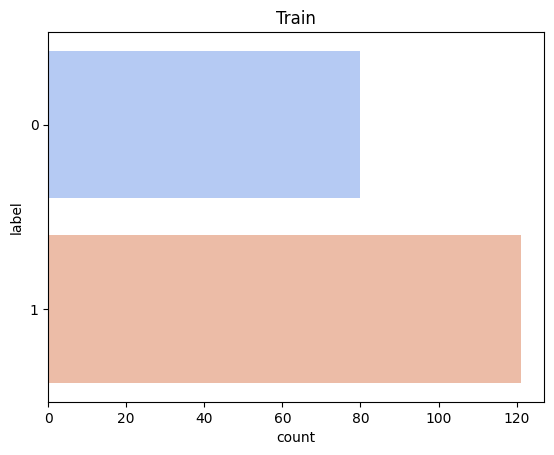

In [2]:
sns.countplot(y="label", palette="coolwarm", data=test_df).set_title('Train')
plt.show()

In [3]:
print(df.shape)
df.isna().sum()

(804, 7)


unit_id            0
article_title      0
article_content    0
source             0
date               0
location           0
labels             0
dtype: int64

In [4]:
print(test_df.shape)
test_df.isna().sum()

(201, 2)


title    0
label    0
dtype: int64

In [5]:
from sklearn.utils import shuffle

df = df[~df['article_title'].isna()][['article_title','labels']]
test_df = test_df[~test_df['title'].isna()][['title','label']]
# Shuffle
df = shuffle(df).reset_index(drop=True)
test_df = shuffle(test_df).reset_index(drop=True)

df.drop_duplicates(subset=['article_title'],keep='first',inplace=True)
test_df.drop_duplicates(subset=['title'],keep='first',inplace=True)

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['article_title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [8]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
test_list_of_words = []

for title in test_df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    test_list_of_words.append(word)


In [9]:
test_unique_words = list(set(word for sentence in test_list_of_words for word in sentence.split()))
test_voc_size = len(test_unique_words)

In [10]:
titles = [text for text in list_of_words]
max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

test_titles = [text for text in test_list_of_words]
test_max_len = 0
test_titles_len = []
for title in test_titles:
    test_titles_len.append(len(title.split()))
    test_max_len = max(len(title.split()), test_max_len)

max_len=max(max_len,test_max_len)
print('Max length of the titles:', max_len)

Max length of the titles: 24


In [11]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
voc_size = test_voc_size + voc_size
train_df, val_df = train_test_split(df, test_size=0.125, random_state=42)

train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(train_df['article_title'])
train_sequences = tokenizer.texts_to_sequences(train_df['article_title'])
val_sequences = tokenizer.texts_to_sequences(val_df['article_title'])
test_sequences = tokenizer.texts_to_sequences(test_df['title'])

max_length = max_len  
padding_type = 'post'
truncating_type = 'post'

padded_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
padded_val = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
x_train, x_val, x_test = padded_train, padded_val, padded_test
y_train, y_val, y_test = train_df['labels'], val_df['labels'], test_df['label']

In [12]:

def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index
glove_embeddings = load_glove_embeddings(glove_file_path)

def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings, 100)

# **LSTM**

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM
voc_size = embedding_matrix.shape[0]
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size, output_dim=embedding_vector_features, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Epoch 1/3
11/11 [==============================] - 9s 57ms/step - loss: 0.6951 - accuracy: 0.5185 - val_loss: 0.6954 - val_accuracy: 0.5052
Epoch 2/3
11/11 [==============================] - 0s 9ms/step - loss: 0.6930 - accuracy: 0.5170 - val_loss: 0.6921 - val_accuracy: 0.5670
Epoch 3/3
11/11 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5185 - val_loss: 0.6938 - val_accuracy: 0.5052


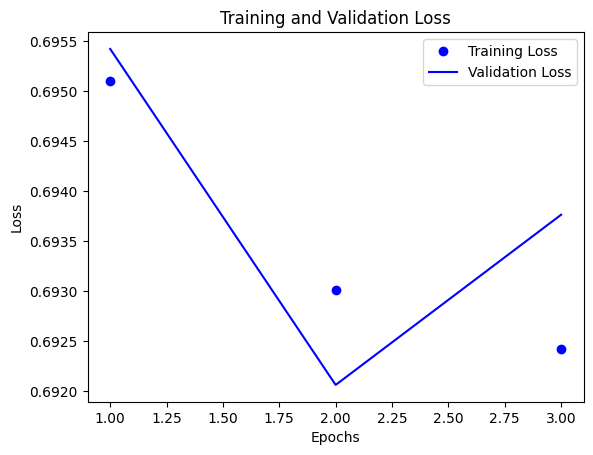

In [14]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 1s 3ms/step
LSTM Model Accuracy :  0.5854922279792746
Precision :  0.5854922279792746
Recall :  1.0
F1 :  0.738562091503268
G-mean: 0.0
Training time:  9.580584287643433
Inference time:  0.7391273975372314
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.59      1.00      0.74       113

    accuracy                           0.59       193
   macro avg       0.29      0.50      0.37       193
weighted avg       0.34      0.59      0.43       193



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

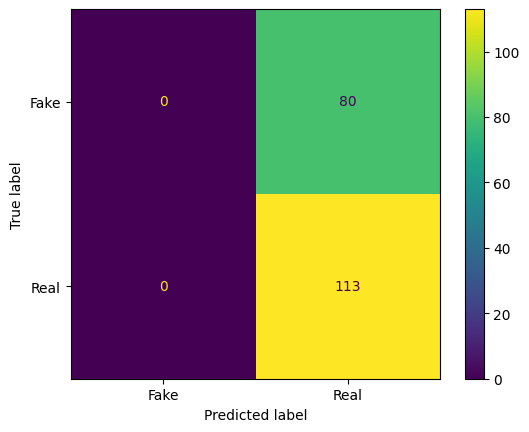

In [15]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("LSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()

**BiLSTM**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM
voc_size = embedding_matrix.shape[0]
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size, output_dim=embedding_vector_features, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/3
11/11 [==============================] - 5s 88ms/step - loss: 0.6994 - accuracy: 0.5066 - val_loss: 0.6955 - val_accuracy: 0.4845
Epoch 2/3
11/11 [==============================] - 0s 10ms/step - loss: 0.6959 - accuracy: 0.4978 - val_loss: 0.6992 - val_accuracy: 0.4948
Epoch 3/3
11/11 [==============================] - 0s 11ms/step - loss: 0.6871 - accuracy: 0.5303 - val_loss: 0.7001 - val_accuracy: 0.4330


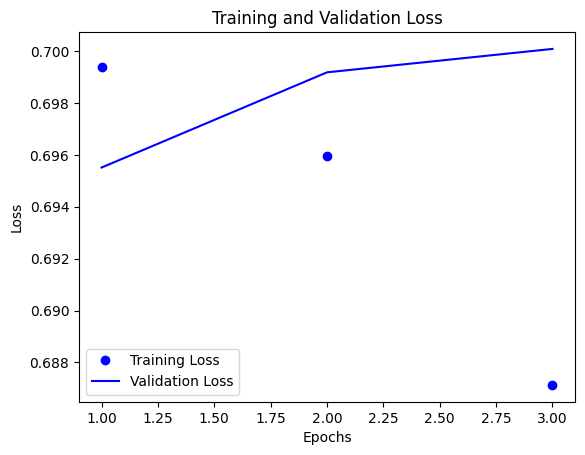

In [17]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 1s 3ms/step
BiLSTM Model Accuracy :  0.48186528497409326
Precision :  0.543046357615894
Recall :  0.7256637168141593
F1 :  0.6212121212121213
G-mean: 0.3158777628481418
Training time:  4.89542031288147
Inference time:  0.7410941123962402
              precision    recall  f1-score   support

           0       0.26      0.14      0.18        80
           1       0.54      0.73      0.62       113

    accuracy                           0.48       193
   macro avg       0.40      0.43      0.40       193
weighted avg       0.43      0.48      0.44       193



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


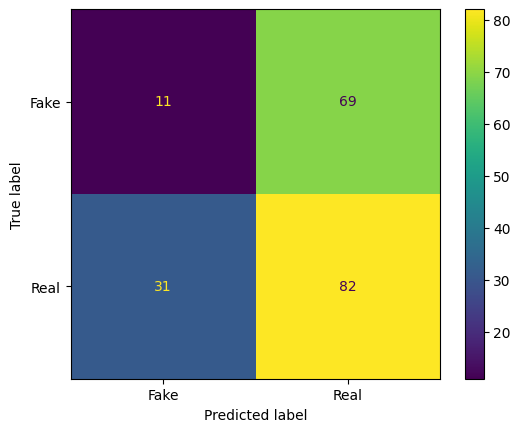

In [18]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()

**CNN-BiLSTM**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM
voc_size = embedding_matrix.shape[0]
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size, output_dim=embedding_vector_features, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/3
11/11 [==============================] - 10s 107ms/step - loss: 0.6929 - accuracy: 0.5214 - val_loss: 0.6992 - val_accuracy: 0.5052
Epoch 2/3
11/11 [==============================] - 0s 11ms/step - loss: 0.6946 - accuracy: 0.5126 - val_loss: 0.6916 - val_accuracy: 0.5258
Epoch 3/3
11/11 [==============================] - 0s 11ms/step - loss: 0.6949 - accuracy: 0.5406 - val_loss: 0.6915 - val_accuracy: 0.5052


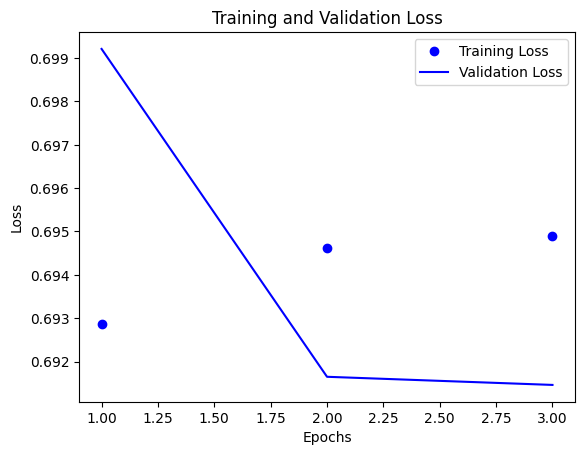

In [20]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 1s 10ms/step
CNN-BiLSTM Model Accuracy :  0.5906735751295337
Precision :  0.5885416666666666
Recall :  1.0
F1 :  0.740983606557377
G-mean: 0.11180339887498951
Training time:  10.03688097000122
Inference time:  0.8484752178192139
              precision    recall  f1-score   support

           0       1.00      0.01      0.02        80
           1       0.59      1.00      0.74       113

    accuracy                           0.59       193
   macro avg       0.79      0.51      0.38       193
weighted avg       0.76      0.59      0.44       193



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


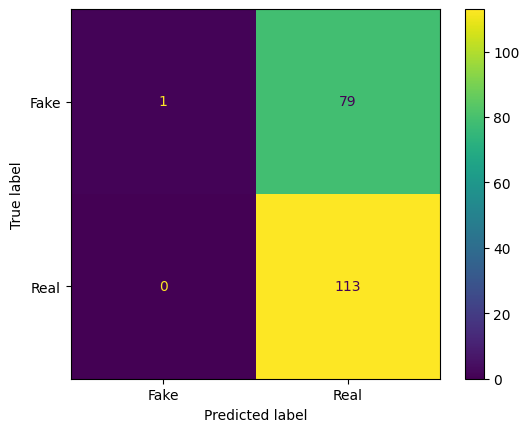

In [21]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()

**BERT**


In [22]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.5 MB/s eta 0:00:00


In [23]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 677
valset size: 97
testset size:  193


In [24]:
sample_idx = 0

statement,label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
First civilians killed in Aleppo since start of ceasefire

tokens: 
['[CLS]', 'first', 'civilians', 'killed', 'in', 'aleppo', 'since', 'start', 'of', 'ceasefire', '[SEP]']

label: 1

--------------------

tokens_tensor: 
tensor([  101,  2034,  9272,  2730,  1999, 22973,  2144,  2707,  1997, 26277,
          102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
1




In [25]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [26]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [27]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [28]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        max_seq_len = 512
        tokens_tensors = tokens_tensors[:, :max_seq_len]
        segments_tensors = segments_tensors[:, :max_seq_len]
        masks_tensors = masks_tensors[:, :max_seq_len]
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors,token_type_ids=segments_tensors, attention_mask=masks_tensors, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

In [29]:
torch.save(model, './best_model.pth')

BERT Model Accuracy :  0.5647668393782384
Precision :  0.5960264900662252
Recall :  0.7964601769911505
F1 :  0.6818181818181819
G-mean: 0.43492446704617366
Training time:  7.792736530303955
Inference time:  0.2877640724182129
              precision    recall  f1-score   support

           0       0.45      0.24      0.31        80
           1       0.60      0.80      0.68       113

    accuracy                           0.56       193
   macro avg       0.52      0.52      0.50       193
weighted avg       0.54      0.56      0.53       193



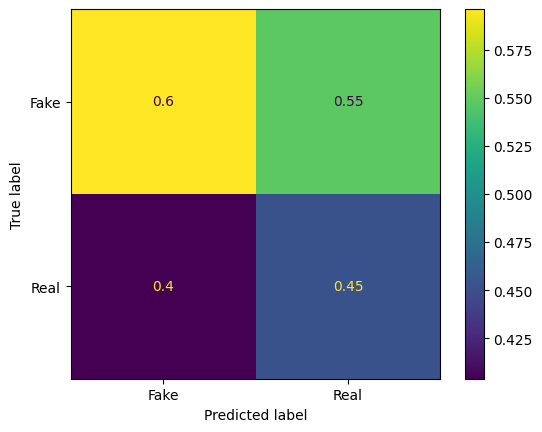

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        max_seq_len = 512
        tokens_tensors = tokens_tensors[:, :max_seq_len]
        segments_tensors = segments_tensors[:, :max_seq_len]
        masks_tensors = masks_tensors[:, :max_seq_len]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()